In [11]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler

# fetch dataset 
iris = fetch_ucirepo(id=53) 

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features 
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

In [12]:
X.head(5)

,sepal length,sepal width,petal length,petal width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [13]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

In [14]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

<font color='red'>NOTE</font>
---
No set seed in this experiment

# Break the data into batches

In [15]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Specify the model architecture and training plan

In [16]:
# a function that creates the ANN model

def model():

    # model architecture
    ANN = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005)

    return ANN,lossfunc,optim

In [17]:
# explore the model in more detail
tmpmodel = model()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0],i[1].shape,i[1].numel()) #name of parameter, size of the parameter, total number of parameters

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


# Question
---
From the above printed parameters, why is layer (1) and (3) missing?

# Function that trains the model

In [21]:
# train the model

# global parameter
epochs = 1000

def train(alpha):
    # initialize accuracies as empties
    train_accuracy = []
    test_accuracy  = []
    losses   = []
    
    # count the total number of weights in the model
    new_weight = 0
    for pname,weight in ANN.named_parameters():
        if 'bias' not in pname: #we should not include the bias term in the L1 regularization (see formula in ppt)
            new_weight = new_weight + weight.numel()
            
    # loop over epochs
    for i in range(epochs):
        # loop over training data batches
        batch_accuracy  = []
        batch_loss = []
        for X,y in train_loader:
            # forward pass and loss
            pred = ANN(X)
            loss = lossfunc(pred,y)
            ### add L1 term
            L1_term = torch.tensor(0.,requires_grad=True) #initialize all L1 terms first to zero
            # sum up all abs(weights)
            for pname,weight in ANN.named_parameters(): #loop at all trainable parameters ()weigths
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
                    
            # add to loss term
            loss = loss + alpha*L1_term/(2*new_weight)
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()

            # compute training accuracy just for this batch
            batch_accuracy.append( 100*torch.mean((torch.argmax(pred,axis=1) == y).float()).item() )
            batch_loss.append( loss.item() )
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        train_accuracy.append( np.mean(batch_accuracy) )
        losses.append( np.mean(batch_loss) )

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax( ANN(X),axis=1 )
        test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return train_accuracy,test_accuracy,losses


# Now for the parameteric experiment

In [22]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

In [23]:
# range of L1 regularization amounts
alpha = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((epochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((epochs,len(L1lambda)))


# loop over batch sizes
for li in range(len(L1lambda)):
    # create and train a model
    ANN,lossfunc,optim = model()
    train_accuracy,test_accuracy,losses = train(L1lambda[li])
    # store data
    accuracyResultsTrain[:,li] = smooth(train_accuracy,10)
    accuracyResultsTest[:,li]  = smooth(test_accuracy,10)

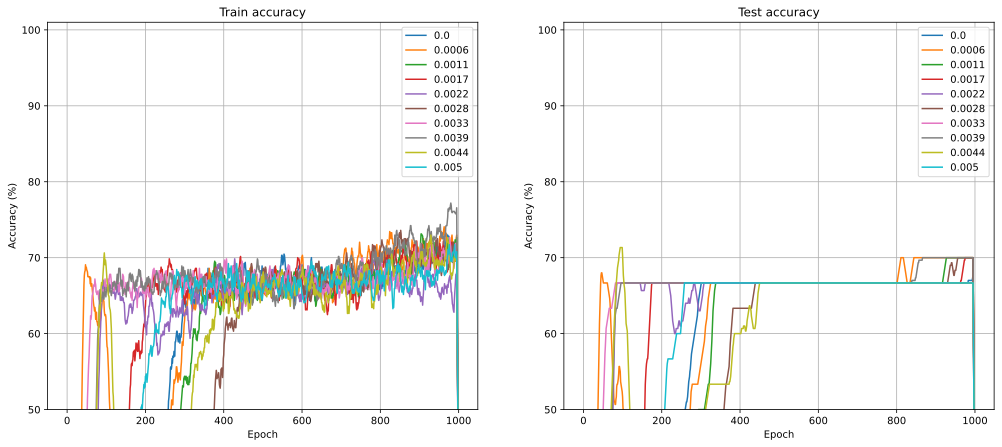

In [24]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()
plt.show()

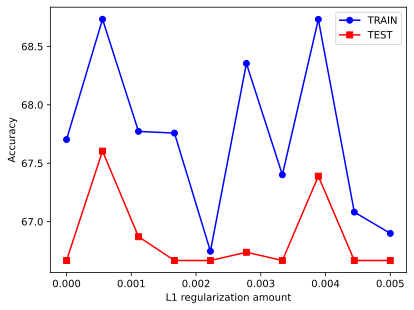

In [25]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Experiment

1. Redo the experiment but this time set the seed in all codes  that requires set seeding to 69.
2. Redo the experiment without the minmax scaler.